# Human Activity Predictive Analysis 

This project focuses on using sensor data to predict human activity and uses the [ExtraSensory dataset](http://extrasensory.ucsd.edu/). You can download the dataset from [here](http://extrasensory.ucsd.edu/data/primary_data_files/ExtraSensory.per_uuid_features_labels.zip) or read more about the dataset in [this README file](http://extrasensory.ucsd.edu/data/primary_data_files/README.txt).

In [36]:
import pandas as pd
import numpy as np
from pathlib import Path
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import statistics


from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC

## Location of the .csv.gz files

In [2]:
data_dir = '/Users/manavsharma/Downloads/data ML/ExtraSensory.per_uuid_features_labels'

## Some utility functions

The first one loads a pandas dataframe given a user UUID. The second one extracts specified feature columns $X$ and target column $y$ from a dataframe and converts these to numpy.

In [3]:
def load_data_for_user(uuid):
    return pd.read_csv(data_dir + '/' + (uuid + '.features_labels.csv.gz'))

def get_features_and_target(df, feature_names, target_name):
    
    # select out features and target columns and convert to numpy
    X = df[feature_names].to_numpy()
    y = df[target_name].to_numpy()
    
    # remove examples with no label
    has_label = ~np.isnan(y)
    X = X[has_label,:]
    y = y[has_label]
    return X, y

## Load in some data 
Load in the data for a user and display the first few rows of the dataframe

In [4]:
df = load_data_for_user('1155FF54-63D3-4AB2-9863-8385D0BD0A13')
df.head()

,timestamp,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,...,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS,label_source
0,1464129912,1.011438,0.012573,0.023013,0.041240,1.006184,1.010868,1.016028,0.935099,6.684536,...,0.0,NaN,0.0,0.0,NaN,NaN,NaN,1.0,0.0,2
1,1464129950,1.011233,0.009356,-0.005622,0.016687,1.006338,1.010926,1.016657,1.732968,6.684569,...,0.0,NaN,0.0,0.0,NaN,NaN,NaN,1.0,0.0,2
2,1464130031,1.013422,0.018068,-0.008593,0.039286,1.004077,1.012983,1.021926,1.464639,6.684453,...,0.0,NaN,0.0,0.0,NaN,NaN,NaN,1.0,0.0,2
3,1464130109,1.014891,0.016400,0.021383,0.038825,1.005934,1.014670,1.023000,1.440043,6.684483,...,0.0,NaN,0.0,0.0,NaN,NaN,NaN,1.0,0.0,2
4,1464130130,1.017487,0.022632,-0.012891,0.037226,1.006040,1.017587,1.028168,1.937362,6.684364,...,0.0,NaN,0.0,0.0,NaN,NaN,NaN,1.0,0.0,2


## What columns are available?

In [5]:
print(df.columns.to_list())

['timestamp', 'raw_acc:magnitude_stats:mean', 'raw_acc:magnitude_stats:std', 'raw_acc:magnitude_stats:moment3', 'raw_acc:magnitude_stats:moment4', 'raw_acc:magnitude_stats:percentile25', 'raw_acc:magnitude_stats:percentile50', 'raw_acc:magnitude_stats:percentile75', 'raw_acc:magnitude_stats:value_entropy', 'raw_acc:magnitude_stats:time_entropy', 'raw_acc:magnitude_spectrum:log_energy_band0', 'raw_acc:magnitude_spectrum:log_energy_band1', 'raw_acc:magnitude_spectrum:log_energy_band2', 'raw_acc:magnitude_spectrum:log_energy_band3', 'raw_acc:magnitude_spectrum:log_energy_band4', 'raw_acc:magnitude_spectrum:spectral_entropy', 'raw_acc:magnitude_autocorrelation:period', 'raw_acc:magnitude_autocorrelation:normalized_ac', 'raw_acc:3d:mean_x', 'raw_acc:3d:mean_y', 'raw_acc:3d:mean_z', 'raw_acc:3d:std_x', 'raw_acc:3d:std_y', 'raw_acc:3d:std_z', 'raw_acc:3d:ro_xy', 'raw_acc:3d:ro_xz', 'raw_acc:3d:ro_yz', 'proc_gyro:magnitude_stats:mean', 'proc_gyro:magnitude_stats:std', 'proc_gyro:magnitude_stat

## Feature selection

The columns that start with `label:` correspond to potential y values. Let's look at using the accelerometer features. These start with `raw_acc:` and `watch_acceleration:`

In [6]:
acc_sensors = [s for s in df.columns if 
               s.startswith('raw_acc:') or 
               s.startswith('watch_acceleration:')]

target_column = 'label:FIX_walking'

## Extract our training data

In [7]:
X_train, y_train = get_features_and_target(df, acc_sensors, target_column)
print(f'{y_train.shape[0]} examples with {y_train.sum()} positives')

2681 examples with 158.0 positives


## Preprocessing

We want to make the learning problem easier by making all columns have a mean of zero and a standard deviation of one. There are also lots of missing values in this dataset. We'll use mean imputation here to get rid of them. Since our data is scaled to have zero mean, this will just zero out missing values.

In [8]:
scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')

X_train = scaler.fit_transform(X_train)
X_train = imputer.fit_transform(X_train)

## Fitting a model
Let's fit a logistic regression model to this user. We can then test it's predictive power on a different user

In [9]:
clf = LogisticRegression(solver='liblinear', max_iter=1000, C=1.0)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Training accuracy

Let's see the accuracy on the training set. The score function can be used to do this:

In [10]:
print(f'Training accuracy: {clf.score(X_train, y_train):0.4f}')

Training accuracy: 0.9750


Looks like the model can fit the training data reasonably well anyway. But this says nothing about how well it will generalize to new data. The dataset is also unbalanced, so this figure may be misleading. How accurate would we be if we just predicted zero each time?

In [11]:
1 - y_train.sum() / y_train.shape[0]

0.9410667661320403

Oh wow. Our model may not be that great after all. Let's try to calculate balanced accuracy, which should better reflect how well the model does on the training data

In [12]:
y_pred = clf.predict(X_train)
print(f'Balanced accuracy (train): {metrics.balanced_accuracy_score(y_train, y_pred):0.4f}')

Balanced accuracy (train): 0.8354


## Testing the model

Ok, it seems our model has fit the training data well. How well does it perform on unseen test data? Let's load the data in for a different user.

In [13]:
df_test = load_data_for_user('11B5EC4D-4133-4289-B475-4E737182A406')
X_test, y_test = get_features_and_target(df_test, acc_sensors, target_column)
print(f'{y_train.shape[0]} examples with {y_train.sum()} positives')

2681 examples with 158.0 positives


We also need to preprocess as before. **Note**: we are using the scaler and imputer fit to the training data here. It's very important that you do not call `fit` or `fit_transform` here! Think about why.

In [14]:
X_test = imputer.transform(scaler.transform(X_test))

## Test accuracy

In [15]:
print(f'Test accuracy: {clf.score(X_test, y_test):0.4f}')

Test accuracy: 0.9746


In [16]:
y_pred = clf.predict(X_test)
print(f'Balanced accuracy (train): {metrics.balanced_accuracy_score(y_test, y_pred):0.4f}')

Balanced accuracy (train): 0.7327


In [17]:
user_list= ['0A986513-7828-4D53-AA1F-E02D6DF9561B','59EEFAE0-DEB0-4FFF-9250-54D2A03D0CF2','99B204C0-DD5C-4BB7-83E8-A37281B8D769','1155FF54-63D3-4AB2-9863-8385D0BD0A13','8023FE1A-D3B0-4E2C-A57A-9321B7FC755F']
acc_list=[]

def make_list(x) :
    acc_list.append(x)
    
for user in user_list: 
    df_test = load_data_for_user(user)
    X_test, y_test = get_features_and_target(df_test, acc_sensors, target_column)
    print("UUID = ",user)
    print(f'{y_train.shape[0]} examples with {y_train.sum()} positives')
    X_test = imputer.transform(scaler.transform(X_test))
    print(f'Test accuracy: {clf.score(X_test, y_test):0.4f}')
    y_pred = clf.predict(X_test)
    print(f'Balanced accuracy (train): {metrics.balanced_accuracy_score(y_test, y_pred):0.4f}')
    x = metrics.balanced_accuracy_score(y_test, y_pred)
    make_list(x)
    print('-'*100)

    

print('-'*100)
#print(acc_list)    
y = sum(acc_list)
y_mean = y/len(acc_list)
print("mean of bal accuracy = ",y_mean)

y_var = statistics.variance(acc_list)
print("variance of bal accuracy = ",y_var)
    

UUID =  0A986513-7828-4D53-AA1F-E02D6DF9561B
2681 examples with 158.0 positives
Test accuracy: 0.9497
Balanced accuracy (train): 0.6765
----------------------------------------------------------------------------------------------------
UUID =  59EEFAE0-DEB0-4FFF-9250-54D2A03D0CF2
2681 examples with 158.0 positives
Test accuracy: 0.9316
Balanced accuracy (train): 0.6187
----------------------------------------------------------------------------------------------------
UUID =  99B204C0-DD5C-4BB7-83E8-A37281B8D769
2681 examples with 158.0 positives
Test accuracy: 0.9081
Balanced accuracy (train): 0.5197
----------------------------------------------------------------------------------------------------
UUID =  1155FF54-63D3-4AB2-9863-8385D0BD0A13
2681 examples with 158.0 positives
Test accuracy: 0.9750
Balanced accuracy (train): 0.8354
----------------------------------------------------------------------------------------------------
UUID =  8023FE1A-D3B0-4E2C-A57A-9321B7FC755F
2681 ex

In [19]:
merged_csv = pd.concat([pd.read_csv(data_dir + '/' + (user + '.features_labels.csv')) for user in user_list])
df_merged = pd.DataFrame(merged_csv)  
df_merged.to_csv("combine_csv.csv", index=False, encoding='utf-8-sig')

In [20]:
df_mergedset = pd.read_csv(data_dir + '/' + "combine_csv.csv" )

In [21]:
X_test, y_test = get_features_and_target(df_mergedset, acc_sensors, target_column)

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=1)

In [23]:
scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')

X_train = scaler.fit_transform(X_train)
X_train = imputer.fit_transform(X_train)

In [24]:
clf = LogisticRegression(solver='liblinear', max_iter=1000, C=1.0)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [47]:
print('Logistic Reg with C-parameter = 1.0 Training Accuracy ',clf.score(X_train, y_train))

Logistic Reg with C-parameter = 1.0 Training Accuracy  0.9734141791044776


In [26]:
1 - y_train.sum() / y_train.shape[0]

0.9393656716417911

In [27]:
X_val = scaler.fit_transform(X_val)
X_val = imputer.fit_transform(X_val)
y_pred = clf.predict(X_val)

print(f'Balanced Accuracy =  {metrics.balanced_accuracy_score(y_val, y_pred):0.4f}')

Balanced Accuracy =  0.8354


In [30]:
print('Logistic Reg with C-parameter = 1.0\n' )
print(classification_report(y_val,y_pred))

Logistic Reg with C-parameter = 1.0

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       509
         1.0       0.83      0.68      0.75        28

    accuracy                           0.98       537
   macro avg       0.90      0.84      0.87       537
weighted avg       0.97      0.98      0.97       537



In [46]:
clf = LogisticRegression(solver='liblinear', max_iter=1000, C=0.6)
clf.fit(X_train, y_train)
print(f'Logistic Reg with C=0.6 Training Accuracy : {clf.score(X_train,y_train):0.4f}')

Logistic Reg with C=0.6 Training Accuracy : 0.9734


In [33]:
1 - y_train.sum() / y_train.shape[0]

0.9393656716417911

In [34]:
X_val = scaler.fit_transform(X_val)
X_val = imputer.fit_transform(X_val)
y_pred = clf.predict(X_val)
print(f'Balanced Accuracy =  {metrics.balanced_accuracy_score(y_val, y_pred):0.4f}')


Balanced Accuracy =  0.8542


In [35]:
print('Logistic Reg with C-parameter = 0.6\n' )
print(classification_report(y_val,y_pred))

Logistic Reg with C-parameter = 0.6

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       509
         1.0       0.87      0.71      0.78        28

    accuracy                           0.98       537
   macro avg       0.93      0.85      0.89       537
weighted avg       0.98      0.98      0.98       537



In [37]:
clf = SVC(C=0.1,kernel = 'sigmoid', gamma= 1)
clf.fit(X_train, y_train)

SVC(C=0.1, gamma=1, kernel='sigmoid')

In [ ]:
1 - y_train.sum() / y_train.shape[0]

In [38]:
X_val = scaler.fit_transform(X_val)
X_val = imputer.fit_transform(X_val)
y_pred = clf.predict(X_val)
print(f'Balanced Accuracy =  {metrics.balanced_accuracy_score(y_val, y_pred):0.4f}')

Balanced Accuracy =  0.5865


In [39]:
print(f'Support Vector Machine with sigmoid kernel classification\n')
print(classification_report(y_val,y_pred))

Support Vector Machine with sigmoid kernel classification

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       509
         1.0       0.22      0.21      0.22        28

    accuracy                           0.92       537
   macro avg       0.59      0.59      0.59       537
weighted avg       0.92      0.92      0.92       537



In [40]:
clf = SVC(C=0.1,kernel = 'rbf', gamma= 1)
clf.fit(X_train, y_train)

SVC(C=0.1, gamma=1)

In [41]:
1 - y_train.sum() / y_train.shape[0]

0.9393656716417911

In [42]:
X_val = scaler.fit_transform(X_val)
X_val = imputer.fit_transform(X_val)
y_pred = clf.predict(X_val)
print(f'Balanced Accuracy =  {metrics.balanced_accuracy_score(y_val, y_pred):0.4f}')

Balanced Accuracy =  0.5000


In [43]:
print(f'Support Vector Machine with rbf kernel classification\n')
print(classification_report(y_val,y_pred))

Support Vector Machine with rbf kernel classification

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       509
         1.0       0.00      0.00      0.00        28

    accuracy                           0.95       537
   macro avg       0.47      0.50      0.49       537
weighted avg       0.90      0.95      0.92       537



/Users/manavsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manavsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manavsharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


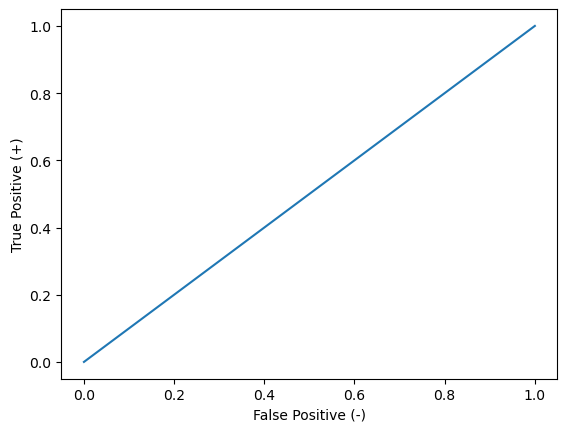

In [45]:
fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred)
auc = metrics.roc_auc_score(y_val, y_pred)

plt.plot(fpr,tpr)
plt.ylabel('True Positive (+)')
plt.xlabel('False Positive (-)')
plt.show()